공통 클래스 구현

In [19]:
import numpy as np

# 전결합층의 부모 클래스
class BaseLayer:
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        

은닉층 구현

In [20]:
# 은닉층
class MiddleLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # He 초깃값
        self.w = np.random.randn(n_upper, n) * np.sqrt(2/n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        self.u = np.dot(x, self.w) + self.b
        self.y = np.where(self.u <= 0, 0, self.u)      # ReLU
        
    def backward(self, grad_y):
        delta = grad_y * np.where(self.u <= 0, 0, 1)   # ReLU 미분
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_d = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

출력층 구현

In [21]:
class OutputLayer(BaseLayer):
    def __init__(self, n_upper, n):
        # 자비에르 초기화 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        # 소프트맥스 함수
        self.y = np.exp(u)/np.sum(np.exp(u), axis=1, keepdims=True)
        
    def backward(self, t):
        delta = self.y - t
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)

3.5.1 손글씨 숫자 이미지 데이터 확인

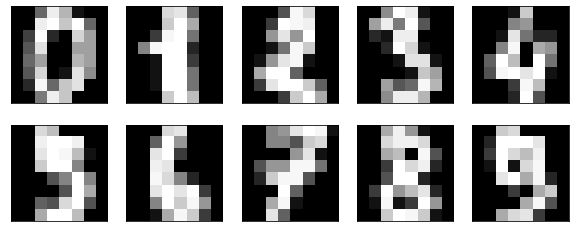

데이터 형태: (1797, 64)
레이블: [0 1 2 3 4 5 6 7 8 9]


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets

# scikit-learn에 포함된 학습용 데이터 활용
digits_data = datasets.load_digits()

n_mid = 16
n_out = 10
n_img = 10          # 출력할 이미지 개수
img_size = 8
eta = 0.001
epochs = 51
batch_size = 32


plt.figure(figsize=(10,4))
for i in range(n_img):
    # 입력 이미지
    ax = plt.subplot(2, 5, i+1)
    plt.imshow(digits_data.data[i].reshape(8, 8), cmap="Greys_r")
    ax.get_xaxis().set_visible(False)    # 축을 표시하지 않음
    ax.get_yaxis().set_visible(False)
plt.show()

print("데이터 형태:", digits_data.data.shape)
print("레이블:", digits_data.target[:n_img])

3.5.2 데이터 전처리

In [23]:
from sklearn.model_selection import train_test_split
import numpy as np

# 입력 데이터
input_data = np.asarray(digits_data.data)
# 평균 0, 표준편차 1
input_data = (input_data - np.average(input_data)) / np.std(input_data)

# 정답 데이터
correct = np.asarray(digits_data.target)
correct_data = np.zeros((len(correct), n_out))
for i in range(len(correct)):
    correct_data[i, correct[i]] = 1       # 원핫 인코딩
    
# 훈련 데이터와 테스트 데이터로 분할
x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

3.5.3 순전파와 역전파

In [24]:
# 각 층의 초기화
layers = [MiddleLayer(img_size*img_size, n_mid),
         MiddleLayer(n_mid, n_mid),
          OutputLayer(n_mid, n_out)]

# 순전파
def forward_propagation(x):
    for layer in layers:
        layer.forward(x)
        x = layer.y
    return x

# 역전파
def backpropagation(t):
    grad_y = t
    for layer in reversed(layers):
        layer.backward(grad_y)
        grad_y = layer.grad_x
    return grad_y

# 파라미터 갱신
def update_params():
    for layer in layers:
        layer.update(eta)

In [25]:
n_batch = len(x_train) // batch_size   # 1에포크당 배치 개수
for i in range(epochs):
    
    # --학습--
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)    # 인덱스를 임의로 섞기
    for j in range(n_batch):
        
        # 미니 배치 구성
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]
        
        # 순잔파와 역전파
        forward_propagation(x_mb)
        backpropagation(t_mb)
        
        # 파라미터 갱신
        update_params()

AttributeError: 'MiddleLayer' object has no attribute 'grad_b'